<a href="https://colab.research.google.com/github/andreiplotnikov/ME/blob/nn/baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/andreiplotnikov/ME

Cloning into 'ME'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 216 (delta 47), reused 64 (delta 20), pack-reused 110
Receiving objects: 100% (216/216), 1.94 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [2]:
import ME
import torch
import torch.nn as nn
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt


In [3]:
import sys
sys.path.append(r"/content/drive/MyDrive/диплом")

from sklearn.model_selection import train_test_split

import numpy as np
import os
import astropy.io.fits as fits
import scipy.stats

from tqdm import tqdm

In [4]:
import os
directory = '/content/drive/My Drive/диплом/'
files = os.listdir(directory+'20140707_015508/')

In [ ]:
lev_1 = fits.open(directory+'20140707_015508/'+files[0])

In [30]:
lev_2 = fits.open(directory+'20140707_015508.fits')

# baseline

In [5]:
base = fits.open('/content/drive/MyDrive/диплом/parameters_base.fits')
base = base[0].data

Та же функция генерации данных, только без оболочки dataset, у меня получалось так, что каждую эпоху генерились новые батчи, а это долго. 

In [9]:
from ME import ME, MEbatch_hs
def data_generation(list_IDs_temp, line_vector, argument, batch_size, base ):
        
        X = np.empty( (batch_size, 11))
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = base[ID]
        
        x_arg = np.broadcast_to(argument, (batch_size, len(argument)))
        
        cont = X[:,6] + line_vector[2]*X[:,7]

        
        X[:,6] /= cont
        X[:,7] /= cont
        
        profile = MEbatch_hs.ME_ff(line_vector, X, x_arg)
        
        noise_level = 100/cont
        noise_level = np.reshape(noise_level, (-1, 1, 1))
        noise = noise_level*np.random.normal(size = profile.shape)
        
        profile += noise
        
        X[:,8] += 10
        X[:,10] += 10
        
        profile[:,:,1:] = profile[:,:,1:]*3
        
        param, prof = np.log1p(X), np.reshape(np.swapaxes(profile, 1, 2), (-1, 4*56))
        
        
        return prof, param
    
def getitem(index, batch_size, argument, line_vector, base):
        list_IDs = np.arange(base.shape[0])
        indexes = np.arange(len(list_IDs))
        indexes = indexes[index*batch_size:(index+1)*batch_size]
        
        list_IDs_temp = [list_IDs[k] for k in indexes]
        
        X, Y = data_generation(list_IDs_temp, l_v, line_arg, batch_size, base)
        return X, Y

In [10]:
spectrum_shape  = 56*4

transitional_shape = 100

dims_names = ['Strength', 'Inclination', 'Azimuth', 'Doppler broadening', 'Damping', 'Line strength',
              'Continuum intensity', 'Source function gradient', 'Doppler shift', 'Filling factor', 'Stray shift']

dims_flags = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

wl0 = 6302.5
g = 2.5
mu = 1
l_v = [wl0, g, mu]

argument = np.linspace(6302.0692255, 6303.2544205, 56)
line_arg = 1000*(argument - wl0)

var_par = 11

In [11]:
x = []
y = []
for i in range(10000):
  xx, yy = getitem(i, 1, line_arg, l_v, base)
  x.append(xx.squeeze())
  y.append(yy.squeeze())


In [12]:
xval = []
yval = []
for i in range(5000):
  xx, yy = getitem(i, 1, line_arg, l_v, base)
  xval.append(xx.squeeze())
  yval.append(yy.squeeze())

## Catboost 

In [ ]:
! pip install catboost
import catboost

In [22]:
field = [i[0] for i in y]

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(x, field)


In [39]:
alist = []
pred = np.zeros((511, 512))
for i in range(511):
  #for t in range(510):
    a = model.predict(full_spectra[i])
    pred[i] = a
    alist.append(a)


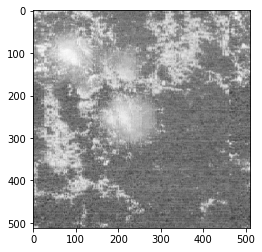

In [28]:
plt.imshow(pred.T, cmap='gray')

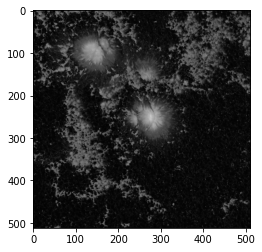

In [ ]:
plt.imshow(lev_2[1].data, cmap='gray')

In [41]:
from sklearn.metrics import r2_score

r2_score(lev_2[1].data,pred.T)

-0.9634773426310587

catboost на удивление справляется лучше, чем все остальное (чисто визуально)

##Персептрон

In [ ]:
class Baseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(224, 882)
    self.ac1 = nn.ReLU()
    self.drop = nn.Dropout(0.2)
    self.fc2 = nn.Linear(882, 100)
    self.ac2 = nn.ELU()
    self.out = nn.Linear(100, 50)
    self.act3 = nn.ELU()
    self.out2 = nn.Linear(50, 11)

  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.ac2(x)
    x = self.out(x)
    x = self.act3(x)
    x = self.out2(x)
    return x


model = Baseline()

model.to('cuda:0')



Baseline(
  (fc1): Linear(in_features=224, out_features=882, bias=True)
  (ac1): ReLU()
  (drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=882, out_features=100, bias=True)
  (ac2): ELU(alpha=1.0)
  (out): Linear(in_features=100, out_features=50, bias=True)
  (tanh): Tanh()
  (out2): Linear(in_features=50, out_features=11, bias=True)
)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        #print(labels)
        inputs = torch.FloatTensor(inputs.float()).to('cuda:0')
        labels = torch.FloatTensor(labels.float()).to('cuda:0')
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        #print('\n', outputs.shape, labels.shape)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)       
        processed_data += inputs.size(0)   
    train_loss = running_loss / processed_data

    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = torch.FloatTensor(inputs.float()).to('cuda:0')
        labels = torch.FloatTensor(labels.float()).to('cuda:0')

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0) 
    val_loss = running_loss / processed_size
    return val_loss

def train(train_data, y, val_data, yv, model, optimizer, criterion, epochs, scheduler, batch_size=256, sch=True, logs=False):
    train_loader = DataLoader(list(zip(train_data, y)), batch_size=batch_size)
    val_loader = DataLoader(list(zip(train_data, yv)), batch_size=batch_size)

    best_valid_loss = float('inf')
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss = eval_epoch(model, val_loader, criterion)
            history.append((train_loss,val_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))
            if sch:
              scheduler.step(val_loss)
            
            if logs:
              if val_loss < best_valid_loss:
                best_valid_loss = val_loss
                torch.save(model.state_dict(), '/content/drive/MyDrive/диплом/modelbaseline_1par.pt')

    return history

In [ ]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4)

hist = train(x, y, xval, yval, model, optimizer, criterion, 100, scheduler=scheduler, logs=True)

Очень плохо получается обучать по одному параметру, лосс совсем не хочет падат

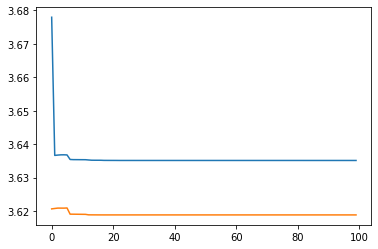

In [ ]:
plt.plot(hist) # это сила поля

Здесь лосс при обучении на 11 параметрах, довольно неплохо обучается

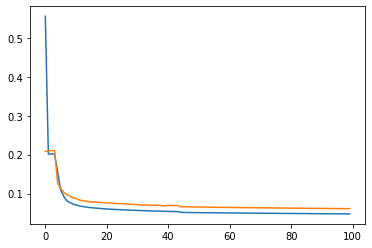

In [ ]:
plt.plot(hist) # здесь MSELoss

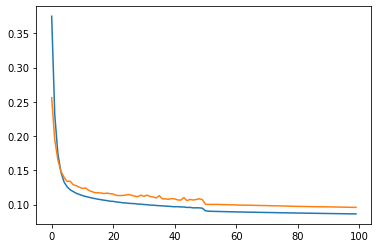

In [ ]:
plt.plot(hist) # здесь MAELoss

In [ ]:
model.eval()
alist = []
pred = np.zeros((512, 511))
for i in range(511):
  for t in range(510):
    with torch.no_grad():
      a = model(torch.FloatTensor(full_spectra[i,t]).to('cuda:0'))
    pred[t, i] = a[0]
    alist.append(a)


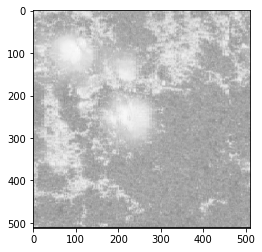

In [ ]:
# картинка после обучения с MSE 
plt.imshow(pred, cmap='gray')

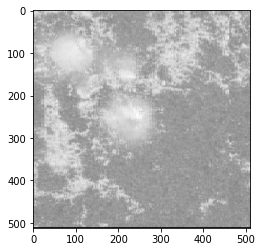

In [ ]:
# картинка после обучения с MAE 
plt.imshow(pred, cmap='gray')

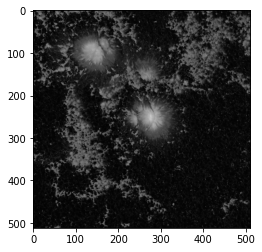

In [ ]:
plt.imshow(lev_2[1].data, cmap='gray')

## Conv1d 


In [ ]:
class Conv1dBaseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(nn.Conv1d(1, 32, 2),
                          nn.MaxPool1d(2),
                          nn.ReLU()
                          )
    
    self.conv2 = nn.Sequential(nn.Conv1d(32, 64, 2), nn.ELU())
    self.out = nn.Linear(64*110, 11)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    #print(x.shape)
    x = x.view(-1, 64*110)
    x = self.out(x)
    return x

convmodel = Conv1dBaseline()
convmodel.to('cuda:0')


Conv1dBaseline(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
    (1): ELU(alpha=1.0)
  )
  (out): Linear(in_features=7040, out_features=11, bias=True)
)

In [ ]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(convmodel.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=4)

hist = train(x, y, xval, yval, convmodel, optimizer, criterion, 100, scheduler=scheduler, logs=True)

In [ ]:
model.eval()
pred = np.zeros((512, 511))
for i in range(511):
  for t in range(510):
    with torch.no_grad():
      a = model(torch.FloatTensor(full_spectra[i,t]).to('cuda:0'))
    pred[t, i] = a[0]


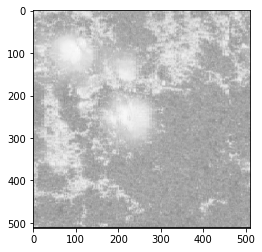

In [ ]:
plt.imshow(pred, cmap='gray') # MAE

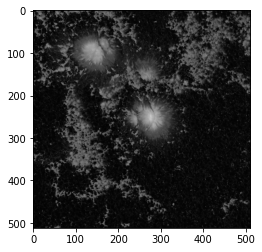

In [ ]:
plt.imshow(lev_2[1].data, cmap='gray')

Если предсказывать по одному параметру, может, там не нужно нормализировать? Либо потом на выходе что-то делать с числами, чтобы они стали больше похожи на то, что было после нормализации. И я не могу понять, почему ничего не обучается по одному параметру

# 3x3

In [ ]:
def make_patches(array, shape, location):
    if shape[0] < location[0] or shape[1] < location[1]:
        return None
    
    borders = ((array.shape[0] - location[0]) % shape[0], (array.shape[1] - location[1]) % shape[1])
    
    end = (array.shape[0] - borders[0], array.shape[1] - borders[1])
    
    subarray = array[location[0]:end[0], location[1]:end[1]].copy()
    
    rows = int(subarray.shape[0] / shape[0])
    cols = int(subarray.shape[1] / shape[1])
    
    
    patches = np.empty((0,) + shape)
    a = np.split(subarray, rows, axis = 0)
    a = np.concatenate(a, axis = 1)
    patches = np.array(np.split(a, rows*cols, axis = 1))
    
    xv, yv = np.meshgrid( location[0] + shape[0]*np.arange(rows), location[1] + shape[1]*np.arange(cols), indexing = 'ij')
    xv = xv.flatten()
    yv = yv.flatten()
    
    return patches, (rows, cols)

def rebuild_from_patches(patches, target_shape, location, rc):
    array = np.empty(target_shape)
    array.fill(np.nan)
    
    rows, cols = rc
    #
    a = np.concatenate(patches, axis = 1)
    print(a.shape)
    a = np.split(a, rows, axis = 1)
    a = np.concatenate(a, axis = 0)
    
    end = np.array(location) + np.array(a.shape[:2])
    array[location[0]:end[0], location[1]:end[1]] = a
    
    return array

In [ ]:
from ME import MEbatch_hs

class Data(torch.utils.data.Dataset):
    def __init__(self, line_vector, argument, 
                 batch_size, base, list_IDs, target_parameter, shuffle = True, device='cuda:0'):
        super(Data).__init__()
        self.line_vector = line_vector
        self.argument = argument
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.base = base
        self.on_epoch_end()
        self.tp = target_parameter
        self.device = device

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty( (self.batch_size, 3, 3, 11))
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = base[ID]
        
        x_arg = np.broadcast_to(self.argument, (9*self.batch_size, len(self.argument)))
        
        cont = X[:,:,:, 6] + self.line_vector[2]*X[:,:,:,7]

        
        X[:,:,:, 6] /= cont
        X[:,:,:, 7] /= cont
        
        profile = MEbatch_hs.ME_ff(self.line_vector, np.reshape(X, (-1, 11)), x_arg)
        
        
        noise_level = np.array([109, 28, 28, 44])
        
        noise_level = np.broadcast_to(noise_level, (profile.shape[0], 4)).T/np.reshape(cont, (-1, 1)).T
        noise_level = np.reshape(noise_level.T, (-1, 1, 4))
        noise = noise_level*np.random.normal(size = profile.shape)
        
        profile += noise
        
        profile[:,:,1:3] = profile[:,:,1:3]*3
        profile[:,:,3] = profile[:,:,3]*3
        
        profile = np.reshape(np.swapaxes(profile, 1, 2), (-1, 4*56))
        
        normalization = np.reshape(np.max(profile, axis = 1), (-1, 1))        
        profile /= normalization
        
        profile = np.reshape(profile, (-1, 3, 3, 4*56))

        param, prof = (X[:,:,:,self.tp])/100, profile
        
        return prof, param

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X, Y = self.__data_generation(list_IDs_temp)
        return X, Y

In [ ]:
spectrum_shape  = (3, 3, 56*4, )

transitional_shape = 100

dims_names = ['Strength', 'Inclination', 'Azimuth', 'Doppler broadening', 'Damping', 'Line strength',
              'Continuum intensity', 'Source function gradient', 'Doppler shift', 'Filling factor', 'Stray shift']

dims_flags = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

wl0 = 6302.5
g = 2.5
mu = 1
l_v = [wl0, g, mu]

argument = np.linspace(6302.0692255, 6303.2544205, 56)
line_arg = 1000*(argument - wl0)

var_par = 11

In [ ]:
base1 = fits.open('/content/drive/MyDrive/диплом/parameters_base3x3.fits')[0].data

base = np.moveaxis(base1, 1, 3)


train, test = train_test_split(base, test_size = 0.1)

In [ ]:
train_data = Data(line_vector = l_v, argument = line_arg, 
                    batch_size = 256, base = train, 
                    list_IDs = np.arange(train.shape[0]), target_parameter = 3)
val_data = Data(line_vector = l_v, argument = line_arg, 
                    batch_size = 256, base = test, 
                    list_IDs = np.arange(train.shape[0]), target_parameter = 3)

Опять же, в оболочке dataset все очень долго работает (я 3 часа ждала 6 эпох)

In [ ]:
def data_generation(list_IDs_temp, line_vector, argument, batch_size, base, tp):
        X = np.empty( (batch_size, 3, 3, 11))
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = base[ID]
        
        x_arg = np.broadcast_to(argument, (9*batch_size, len(argument)))
        
        cont = X[:,:,:, 6] + line_vector[2]*X[:,:,:,7]

        
        X[:,:,:, 6] /= cont
        X[:,:,:, 7] /= cont
        
        profile = MEbatch_hs.ME_ff(line_vector, np.reshape(X, (-1, 11)), x_arg)
        
        
        noise_level = np.array([109, 28, 28, 44])
        
        noise_level = np.broadcast_to(noise_level, (profile.shape[0], 4)).T/np.reshape(cont, (-1, 1)).T
        noise_level = np.reshape(noise_level.T, (-1, 1, 4))
        noise = noise_level*np.random.normal(size = profile.shape)
        
        profile += noise
        
        profile[:,:,1:3] = profile[:,:,1:3]*3
        profile[:,:,3] = profile[:,:,3]*3
        
        profile = np.reshape(np.swapaxes(profile, 1, 2), (-1, 4*56))
        
        normalization = np.reshape(np.max(profile, axis = 1), (-1, 1))        
        profile /= normalization
        
        profile = np.reshape(profile, (-1, 3, 3, 4*56))

        param, prof = (X[:,:,:,tp])/100, profile
        
        return prof, param



def getitem(index, batch_size, argument, line_vector, base, tp=3):
        list_IDs = np.arange(base.shape[0])
        indexes = np.arange(len(list_IDs))
        indexes = indexes[index*batch_size:(index+1)*batch_size]
        
        list_IDs_temp = [list_IDs[k] for k in indexes]
        
        X, Y =data_generation(list_IDs_temp, line_vector, argument, batch_size, base, tp)
        return X, Y

In [ ]:
x = []
y = []
for i in range(10000):
  xx, yy = getitem(i, 1, line_arg, l_v, train)
  x.append(xx)
  y.append(yy)


In [ ]:
xv = []
yv = []
for i in range(1000):
  xx, yy = getitem(i, 1, line_arg, l_v, test)
  xv.append(xx)
  yv.append(yy)


## Conv2d

In [ ]:
class ConvModel(nn.Module):
  def __init__(self, parameters_shape = 1, spectrum_shape = (3, 3, 56*4)):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, 2),
        nn.ReLU())
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 2)
        #nn.MaxPool1d(2),
        #nn.BatchNorm2d(64)
    )
    self.conv3 = nn.Sequential(nn.Conv2d(64, 256, 1),
        nn.ReLU())
    self.conv4 = nn.Sequential(
        nn.Conv2d(256, 512, 1),
        nn.ReLU()
    )

    self.fc1 = nn.Linear(222*512, 9)
    #self.out = nn.Tanh()

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    #print('\n', x.shape)
    x = x.view(-1, 512*222)
    x = self.fc1(x)
    #x = self.out(x)
    #print(x.shape)
    return x

model = ConvModel()
model.to('cuda:0')

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=113664, out_features=9, bias=True)
)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        #print(labels)
        inputs = torch.FloatTensor(inputs.float()).to('cuda:0').squeeze()
        labels = torch.FloatTensor(labels.float()).to('cuda:0').squeeze()
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        #print('\n', outputs.shape, labels.shape)
        loss= criterion(outputs.view(outputs.shape[0], 3, 3), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)       
        processed_data += inputs.size(0)   
    train_loss = running_loss / processed_data

    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = torch.FloatTensor(inputs.float()).to('cuda:0').squeeze()
        labels = torch.FloatTensor(labels.float()).to('cuda:0').squeeze()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            #print(outputs.shape)
            loss = criterion(outputs.view(outputs.shape[0], 3, 3), labels)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0) 
    val_loss = running_loss / processed_size
    return val_loss

def train(train_data, y, val_data, yv, model, optimizer, criterion, epochs, scheduler, batch_size=256, sch=True, logs=False):
    train_loader = DataLoader(list(zip(train_data, y)), batch_size=batch_size)
    val_loader = DataLoader(list(zip(train_data, yv)), batch_size=batch_size)

    best_valid_loss = float('inf')
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss = eval_epoch(model, val_loader, criterion)
            history.append((train_loss,val_loss))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))
            if sch:
              scheduler.step(val_loss)
            
            if logs:
              if val_loss < best_valid_loss:
                best_valid_loss = val_loss
                torch.save(model.state_dict(), '/content/drive/MyDrive/диплом/resnet18.pt')

    return history

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

hist = train(x, y, xv, yv, model, optimizer, criterion, 10, scheduler=scheduler, logs=True)

## маленькая resnet 

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18()


In [ ]:
resnet18.fc = nn.Linear(512, 9)
resnet18.to('cuda:0')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
hist = train(x, y, xv, yv, resnet18, optimizer, criterion, 50, scheduler=scheduler, logs=True)

epoch:   2%|▏         | 1/50 [00:07<06:04,  7.44s/it]


Epoch 001 train_loss: 0.0183     val_loss 0.0169


epoch:   4%|▍         | 2/50 [00:14<05:56,  7.43s/it]


Epoch 002 train_loss: 0.0282     val_loss 0.0138


epoch:   6%|▌         | 3/50 [00:22<05:50,  7.45s/it]


Epoch 003 train_loss: 0.0092     val_loss 0.0116


epoch:   8%|▊         | 4/50 [00:29<05:45,  7.50s/it]


Epoch 004 train_loss: 0.0081     val_loss 0.0141


epoch:  10%|█         | 5/50 [00:37<05:36,  7.49s/it]


Epoch 005 train_loss: 0.0078     val_loss 0.0127


epoch:  12%|█▏        | 6/50 [00:44<05:29,  7.49s/it]


Epoch 006 train_loss: 0.0075     val_loss 0.0131


epoch:  14%|█▍        | 7/50 [00:52<05:23,  7.52s/it]


Epoch 007 train_loss: 0.0070     val_loss 0.0131


epoch:  16%|█▌        | 8/50 [01:00<05:17,  7.57s/it]


Epoch 008 train_loss: 0.0068     val_loss 0.0132


epoch:  18%|█▊        | 9/50 [01:07<05:13,  7.64s/it]


Epoch 009 train_loss: 0.0068     val_loss 0.0123


epoch:  20%|██        | 10/50 [01:15<05:08,  7.70s/it]


Epoch 010 train_loss: 0.0066     val_loss 0.0124


epoch:  22%|██▏       | 11/50 [01:23<05:03,  7.77s/it]


Epoch 011 train_loss: 0.0065     val_loss 0.0127


epoch:  24%|██▍       | 12/50 [01:31<04:58,  7.85s/it]


Epoch 012 train_loss: 0.0064     val_loss 0.0125


epoch:  26%|██▌       | 13/50 [01:40<04:55,  7.98s/it]


Epoch 013 train_loss: 0.0064     val_loss 0.0127


epoch:  28%|██▊       | 14/50 [01:48<04:50,  8.08s/it]


Epoch 014 train_loss: 0.0062     val_loss 0.0127
Epoch    14: reducing learning rate of group 0 to 3.0000e-05.


epoch:  30%|███       | 15/50 [01:56<04:46,  8.20s/it]


Epoch 015 train_loss: 0.0058     val_loss 0.0123


epoch:  32%|███▏      | 16/50 [02:05<04:42,  8.31s/it]


Epoch 016 train_loss: 0.0056     val_loss 0.0123


epoch:  34%|███▍      | 17/50 [02:14<04:37,  8.40s/it]


Epoch 017 train_loss: 0.0056     val_loss 0.0123


epoch:  36%|███▌      | 18/50 [02:22<04:29,  8.43s/it]


Epoch 018 train_loss: 0.0056     val_loss 0.0123


epoch:  38%|███▊      | 19/50 [02:30<04:20,  8.42s/it]


Epoch 019 train_loss: 0.0055     val_loss 0.0123


epoch:  40%|████      | 20/50 [02:39<04:11,  8.39s/it]


Epoch 020 train_loss: 0.0055     val_loss 0.0124


epoch:  42%|████▏     | 21/50 [02:47<04:02,  8.36s/it]


Epoch 021 train_loss: 0.0055     val_loss 0.0124


epoch:  44%|████▍     | 22/50 [02:55<03:53,  8.34s/it]


Epoch 022 train_loss: 0.0055     val_loss 0.0124


epoch:  46%|████▌     | 23/50 [03:04<03:44,  8.33s/it]


Epoch 023 train_loss: 0.0055     val_loss 0.0124


epoch:  48%|████▊     | 24/50 [03:12<03:36,  8.34s/it]


Epoch 024 train_loss: 0.0055     val_loss 0.0125


epoch:  50%|█████     | 25/50 [03:20<03:28,  8.36s/it]


Epoch 025 train_loss: 0.0054     val_loss 0.0125
Epoch    25: reducing learning rate of group 0 to 3.0000e-06.


epoch:  52%|█████▏    | 26/50 [03:29<03:21,  8.39s/it]


Epoch 026 train_loss: 0.0054     val_loss 0.0125


epoch:  54%|█████▍    | 27/50 [03:37<03:13,  8.42s/it]


Epoch 027 train_loss: 0.0053     val_loss 0.0125


epoch:  56%|█████▌    | 28/50 [03:46<03:05,  8.43s/it]


Epoch 028 train_loss: 0.0053     val_loss 0.0125


epoch:  58%|█████▊    | 29/50 [03:54<02:57,  8.43s/it]


Epoch 029 train_loss: 0.0053     val_loss 0.0125


epoch:  60%|██████    | 30/50 [04:03<02:48,  8.43s/it]


Epoch 030 train_loss: 0.0053     val_loss 0.0125


epoch:  62%|██████▏   | 31/50 [04:11<02:40,  8.42s/it]


Epoch 031 train_loss: 0.0053     val_loss 0.0125


epoch:  64%|██████▍   | 32/50 [04:20<02:31,  8.42s/it]


Epoch 032 train_loss: 0.0053     val_loss 0.0126


epoch:  66%|██████▌   | 33/50 [04:28<02:23,  8.42s/it]


Epoch 033 train_loss: 0.0053     val_loss 0.0126


epoch:  68%|██████▊   | 34/50 [04:36<02:14,  8.42s/it]


Epoch 034 train_loss: 0.0053     val_loss 0.0126


epoch:  70%|███████   | 35/50 [04:45<02:06,  8.42s/it]


Epoch 035 train_loss: 0.0053     val_loss 0.0126


epoch:  72%|███████▏  | 36/50 [04:53<01:57,  8.41s/it]


Epoch 036 train_loss: 0.0053     val_loss 0.0126
Epoch    36: reducing learning rate of group 0 to 3.0000e-07.


epoch:  74%|███████▍  | 37/50 [05:02<01:49,  8.41s/it]


Epoch 037 train_loss: 0.0053     val_loss 0.0125


epoch:  76%|███████▌  | 38/50 [05:10<01:40,  8.40s/it]


Epoch 038 train_loss: 0.0053     val_loss 0.0126


epoch:  78%|███████▊  | 39/50 [05:18<01:32,  8.39s/it]


Epoch 039 train_loss: 0.0053     val_loss 0.0126


epoch:  80%|████████  | 40/50 [05:27<01:23,  8.38s/it]


Epoch 040 train_loss: 0.0053     val_loss 0.0126


epoch:  82%|████████▏ | 41/50 [05:35<01:15,  8.38s/it]


Epoch 041 train_loss: 0.0053     val_loss 0.0126


epoch:  84%|████████▍ | 42/50 [05:43<01:07,  8.38s/it]


Epoch 042 train_loss: 0.0053     val_loss 0.0126


epoch:  86%|████████▌ | 43/50 [05:52<00:58,  8.38s/it]


Epoch 043 train_loss: 0.0053     val_loss 0.0126


epoch:  88%|████████▊ | 44/50 [06:00<00:50,  8.38s/it]


Epoch 044 train_loss: 0.0053     val_loss 0.0126


epoch:  90%|█████████ | 45/50 [06:09<00:41,  8.39s/it]


Epoch 045 train_loss: 0.0053     val_loss 0.0126


epoch:  92%|█████████▏| 46/50 [06:17<00:33,  8.40s/it]


Epoch 046 train_loss: 0.0053     val_loss 0.0126


epoch:  94%|█████████▍| 47/50 [06:25<00:25,  8.41s/it]


Epoch 047 train_loss: 0.0053     val_loss 0.0126
Epoch    47: reducing learning rate of group 0 to 3.0000e-08.


epoch:  96%|█████████▌| 48/50 [06:34<00:16,  8.42s/it]


Epoch 048 train_loss: 0.0053     val_loss 0.0126


epoch:  98%|█████████▊| 49/50 [06:42<00:08,  8.43s/it]


Epoch 049 train_loss: 0.0053     val_loss 0.0126


epoch: 100%|██████████| 50/50 [06:51<00:00,  8.23s/it]


Epoch 050 train_loss: 0.0053     val_loss 0.0126


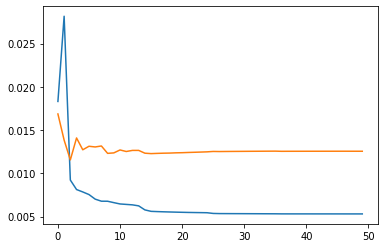

In [ ]:
plt.plot(hist)

Далее я навставляла всякий код в надежде, чт он пригодится

In [ ]:
def check_real(x_c, y_c):
    directory = '/content/drive/MyDrive/диплом/20140707_015508'
    files_list = os.listdir(directory)
    spectra_file = fits.open(directory + files_list[x_c])
    real_I = spectra_file[0].data[0][y_c][56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][y_c][56:].astype('float64')
    real_U = spectra_file[0].data[2][y_c][56:].astype('float64')
    real_V = spectra_file[0].data[3][y_c][56:].astype('float64')
            
                
    real_sp = np.concatenate((real_I, real_Q, real_U, real_V))
    
    normalization = np.max(real_sp)
    
    real_sp /= normalization
    
    pred_params = np.reshape(inversion.predict(np.reshape(real_sp, (1, 224))), (11))
    
    pred_params = np.expm1(pred_params)
    pred_params[8] -= 10
    pred_params[10] -= 10
    print(pred_params)
    
    pred_spectra = np.reshape(MEbatch_hs.ME_ff(l_v, pred_params, line_arg).T, (224, 1))
    
    pred_spectra /= np.max(pred_spectra)
    
    plot_spectrum(real_sp)
    plot_spectrum(pred_spectra)
    plt.show()
    
def params_from_real(x_c, y_c):
    directory = '/content/drive/MyDrive/диплом/20140707_015508'
    files_list = os.listdir(directory)
    spectra_file = fits.open(directory + files_list[x_c])
    real_I = spectra_file[0].data[0][y_c][56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][y_c][56:].astype('float64')*10
    real_U = spectra_file[0].data[2][y_c][56:].astype('float64')*10
    real_V = spectra_file[0].data[3][y_c][56:].astype('float64')*5
                
    real_sp = np.concatenate((real_I, real_Q, real_U, real_V))
    
    real_sp /= np.max(real_sp)
    
    pred_params = np.reshape(inversion.predict(np.reshape(real_sp, (1, 224))), (11))
    
    pred_params = np.expm1(pred_params)
    pred_params[8] -= 10
    pred_params[10] -= 10
    
    print('predicted first: ', pred_params)
    
    pred_spectra = np.reshape(MEbatch_hs.ME_ff(l_v, pred_params, line_arg).T, (224, 1))
    
    pred_spectra /= np.max(pred_spectra)
    
    pred_params_2 = np.reshape(inversion.predict(np.reshape(pred_spectra, (1, 224))), (11))
    
    pred_params_2 = np.expm1(pred_params_2)
    pred_params_2[8] -= 10
    pred_params_2[10] -= 10
    
    print('predicted second: ', pred_params_2)
    
    pred_spectra_2 = np.reshape(MEbatch_hs.ME_ff(l_v, pred_params_2, line_arg).T, (224, 1))
    
    pred_spectra_2 /= np.max(pred_spectra_2)
    
    plot_spectrum(pred_spectra)
    plot_spectrum(pred_spectra_2)
    plt.show()
    


In [14]:
parameters_names = ['Strength', 'Inclination', 'Azimuth', 'Doppler broadening', 'Damping', 'Line strength',
              'Continuum intensity', 'Source function gradient', 'Doppler shift', 'Filling factor', 'Stray shift']            
            
patch_shape = (3, 3)    


refer = fits.open("/content/drive/MyDrive/диплом/20140707_015508.fits")

a = os.listdir('/content/drive/MyDrive/диплом/20140707_015508')
files_list = list('/content/drive/MyDrive/диплом/20140707_015508/' + i for i in a)

In [15]:
Y_len, X_len = refer[1].data.shape 
full_spectra = np.empty((X_len, Y_len, 4*56))
normalization_map = np.empty((X_len, Y_len))

loc_inverted_params = np.empty( (np.prod(patch_shape), X_len, Y_len, 11))

inverted_params = np.empty( (X_len, Y_len, 11))

scaling = np.empty(X_len)

#start = time.time()

In [16]:
for X_count in tqdm(range(X_len)):
    #print(X_count, files_list[X_count])
    spectra_file = fits.open(files_list[X_count])

    
    scaling[X_count] = spectra_file[0].header.get('SPBSHFT') 
    
    real_I = spectra_file[0].data[0][:,56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][:,56:].astype('float64')*3
    real_U = spectra_file[0].data[2][:,56:].astype('float64')*3
    real_V = spectra_file[0].data[3][:,56:].astype('float64')*3
            
    real_sp = np.concatenate((real_I, real_Q, real_U, real_V), axis = 1)
        
    normalization = np.reshape(np.max(real_sp, axis = 1), (-1, 1))
    real_sp /= normalization
    
    normalization_map[X_count] = normalization.flatten()
    
    full_spectra[X_count] = real_sp

100%|██████████| 511/511 [13:48<00:00,  1.62s/it]


In [ ]:
for target_parameter in [3]:
    #print(parameters_names[target_parameter])
    
    inversion = resnet18
    inversion.eval()
    for loc in tqdm(range(np.prod(patch_shape))):
        X_loc = loc // patch_shape[0]
        Y_loc = loc % patch_shape[0] 
        
        location = (X_loc, Y_loc)
        
        patches, rc = make_patches(full_spectra[:100], (3,3,224), location) # здесь беру только 100, потому что полностью не лезет на gpu
        
        with torch.set_grad_enabled(False):
          i_patches = inversion(torch.FloatTensor(patches).to('cuda:0'))
        i_patches = i_patches.cpu().numpy()
        i_patches = i_patches.reshape((i_patches.shape[0], 3, 3))
        loc_inverted_params[loc, :, :, target_parameter] = rebuild_from_patches(i_patches, inverted_params[:, :, 0].shape, location, rc)
        torch.cuda.empty_cache()


не весь спектр, поэтому здесь получается всякая ерунда

Или это потому, что я делаю что-то не так?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


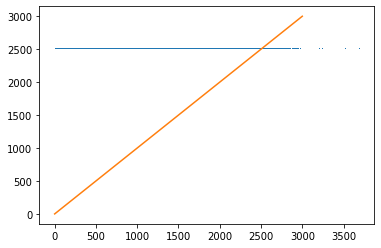

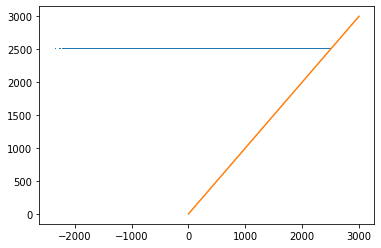

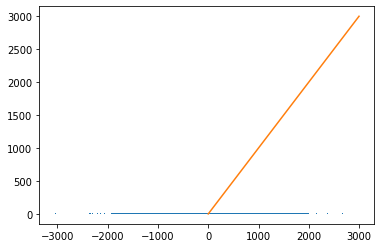

Pearson's r:
Field strength:  nan
Field inclination:  nan
Field azimuth:  nan
Doppler broadening:  -0.015922357370153416


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Damping:  nan
Line strength:  nan
Continuum intensity:  nan
Source function gradient:  nan
Doppler shift:  nan
Filling factor:  nan
Stray shift:  nan


In [ ]:
inverted_params = np.nanmean(loc_inverted_params, axis = 0)
        
#print('Time: ', time.time() - start)
inverted_params = np.swapaxes(inverted_params, 0, 2)

inverted_params[0] = inverted_params[0]*5000 + 2500
inverted_params[1] = inverted_params[1]*180
inverted_params[2] = inverted_params[2]*180
inverted_params[3] = inverted_params[3]*100
inverted_params[4] = inverted_params[4] + 1
inverted_params[5] = (inverted_params[5])*100 + 50

inverted_params = np.nan_to_num(inverted_params)

plt.plot(refer[1].data.flatten(), inverted_params[0].flatten(), ',')
plt.plot([0, 3000], [0, 3000])
plt.show()

Bz = inverted_params[0]*np.cos(np.radians(inverted_params[1]))
refer_Bz = refer[1].data * np.cos(np.radians(refer[2].data))

Bx = inverted_params[0]*np.sin(np.radians(inverted_params[1]))*np.cos(np.radians(inverted_params[2]))
refer_Bx = refer[1].data * np.sin(np.radians(refer[2].data)) * np.cos(np.radians(refer[3].data))

plt.plot(refer_Bz.flatten(), Bz.flatten(), ',')
plt.plot([0, 3000], [0, 3000])
plt.show()

plt.plot(refer_Bx.flatten(), Bx.flatten(), ',')
plt.plot([0, 3000], [0, 3000])
plt.show()


print('Pearson\'s r:')
print('Field strength: ', scipy.stats.pearsonr(refer[1].data.flatten(), inverted_params[0].flatten())[0])
print('Field inclination: ', scipy.stats.pearsonr(refer[2].data.flatten(), (180/np.pi)*inverted_params[1].flatten())[0])
print('Field azimuth: ', scipy.stats.pearsonr(refer[3].data.flatten(), (180/np.pi)*inverted_params[2].flatten())[0])
print('Doppler broadening: ', scipy.stats.pearsonr(refer[6].data.flatten(), inverted_params[3].flatten())[0])
print('Damping: ', scipy.stats.pearsonr(refer[8].data.flatten(), inverted_params[4].flatten())[0])
print('Line strength: ', scipy.stats.pearsonr(refer[7].data.flatten(), inverted_params[5].flatten())[0])
print('Continuum intensity: ', scipy.stats.pearsonr(refer[33].data.flatten(), inverted_params[6].flatten())[0])
print('Source function gradient: ', scipy.stats.pearsonr(refer[10].data.flatten(), inverted_params[7].flatten())[0])
print('Doppler shift: ', scipy.stats.pearsonr(refer[5].data.flatten(), inverted_params[8].flatten())[0])
print('Filling factor: ', scipy.stats.pearsonr(refer[12].data.flatten(), inverted_params[9].flatten())[0])
print('Stray shift: ', scipy.stats.pearsonr(refer[13].data.flatten(), inverted_params[10].flatten())[0])

def show_plots():
    for i, j in enumerate([1, 2, 3, 6, 8, 7, 33, 10, 5, 12, 13]):
        plt.plot(refer[j].data.flatten(), inverted_params[i].flatten(), ',')
        #plt.plot([np.min(refer[j].data), np.max(refer[j].data)], [np.min(refer[j].data), np.max(refer[j].data)])
        plt.show()